## Determination of Negative Modes

The purpose of this notebook is to determine the negative modes of the connected wormhole solution.

In [1]:
import numpy as np
from scipy import linalg
from scipy.special import ellipkinc
import sympy

sympy.init_printing()

### Preliminaries

In [2]:
r, r_0, L, lam = sympy.symbols("r r_0 L lambda")

In [3]:
# spherical part of the metric
g = sympy.Function("g")(r)
dg = sympy.diff(g, r)

g_sol = r ** 2 + r_0 ** 2
dg_sol = sympy.diff(g_sol, r)

def g_func(r, r_0):
    return r ** 2 + r_0 ** 2
def dg_func(r):
    return 2 * r

In [4]:
# radial part of the metric
f = sympy.Function("f")(r)
df = sympy.diff(f, r)

f_sol = (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
df_sol = sympy.diff(f_sol, r)

def f_func(r, r_0, L):
    return (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
def df_func(r, L):
    return 2 * r / L ** 2

In [5]:
# gauge field
Phi = sympy.Function("Phi")(r)
dPhi = sympy.diff(Phi, r)
ddPhi = sympy.diff(dPhi, r)

In [6]:
def get_a(b):
    """Get a based on b."""
    return np.sqrt(2 * b ** 2 + 1)

def get_phi_star(b):
    """Get phi star based on b."""
    return b * np.sqrt(b ** 2 + 1) / 2

def get_ellip_m_param(a, b):
    """Get the elliptic integral parameter m based on a and b."""
    return 1 - a ** 2 / b ** 2

In [7]:
def phi_of_r(r, b, L):
    """Get gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)
    return phi_star * np.cosh((2 / b) * ellipkinc(phi, m))

In [8]:
def dphi_of_r(r, b, L):
    """Get radial derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan(r / (L * a))
    denom = np.sqrt((L * a * b) ** 2 + (a ** 2 + b ** 2) * r ** 2 + r ** 4 / L ** 2)
    return phi_star * np.sinh((2 / b) * ellipkinc(phi, m)) * 2 / denom

In [9]:
def ddphi_of_r(r, b, L):
    """Get second derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)

    phi = np.arctan2(r, L * a)
    sin_part = np.sinh((2 / b) * ellipkinc(phi, m))
    cos_part = np.cosh((2 / b) * ellipkinc(phi, m))

    first_term = 2 * L * (a ** 2 * L ** 2 + r ** 2) ** 2 * cos_part / (b ** 2 * L ** 2 + r ** 2)

    fac1 = a ** 2 * L ** 2 + b ** 2 * L ** 2 + 2 * r ** 2
    fac2 = a ** 2 * (b ** 2 * L ** 2 + r ** 2) / (b ** 2 * (a ** 2 * L ** 2 + r ** 2))
    second_term = a ** 3 * r * fac1 * sin_part / (b ** 3 * fac2 ** (3. / 2))

    return 2 * L * phi_star * (first_term - second_term) / (a ** 2 * L ** 2 + r ** 2) ** 3

In [10]:
q = sympy.Function("q")(r)
dq = sympy.diff(q, r)
ddq = sympy.diff(dq, r)

K = sympy.Function("K")(r)
dK = sympy.diff(K, r)
K_sol = 6 * L ** 2 * r ** 2 / (r ** 2 - g * L ** 2 * dPhi ** 2)

V = sympy.Function("V")(r)
V_sol = (4 * K_sol / g) * ((2 * g) / (L ** 2 * f * r) * ((L ** 2 * (r - L ** 2 * Phi * dPhi) + g * (r - 2 * L ** 2 * Phi * dPhi)) / (r ** 2 - g * L ** 2 * dPhi ** 2)) - 1)

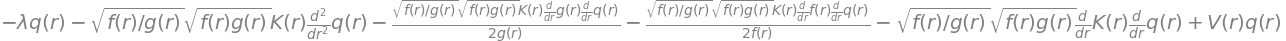

In [11]:
eigen = -sympy.sqrt(f / g) * sympy.diff(sympy.sqrt(f * g) * K * dq, r) + V * q - lam * q
eigen.expand()

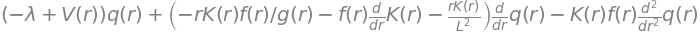

In [12]:
eigen = -lam * q - r * f * K * dq / g - f * K * ddq - f * dK * dq + V * q - r * K * dq / L ** 2
eigen.collect([q, dq])

Separate the terms.

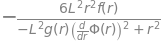

In [13]:
ddq_factor = (-K * f).subs({K: K_sol})
ddq_factor

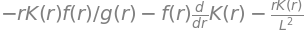

In [14]:
dq_factor = -r * K * f / g - r * K / L ** 2 - f * dK
dq_factor

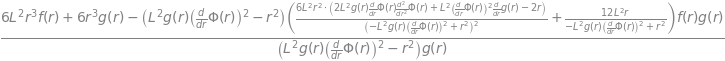

In [15]:
dq_factor = dq_factor.subs({K: K_sol}).simplify()
dq_factor

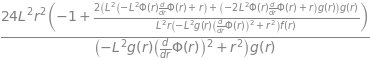

In [16]:
q_factor = V.subs({V: V_sol})
q_factor

#### Discretize

The idea is to tune r_0, the length of the wormhole throat, and determine the eigenvalue. Since r_0 = bL, this amounts to tuning b. Therefore, all functions should depend on b.

For numerical convenience, we will make the change of variables r = r_0 * y / (1 - y) = bLy / (1 - y).

First, form a grid.

In [17]:
def cheb(N, x_minus, x_plus):
    def get_a_j(x, j):
        a = 1
        for k in range(len(x)):
            if k != j:
                a *= x[j] - x[k]
        return a

    x = (x_plus + x_minus) / 2 + (x_plus - x_minus) / 2 * np.cos(np.pi * np.arange(0, N + 1) / N)

    D = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        a_i = get_a_j(x, i)
        for j in range(N + 1):
            if j != i:
                # diagonal element
                D[i, i] += 1 / (x[i] - x[j])
                # off diagonal element
                a_j = get_a_j(x, j)
                D[i, j] = a_i / (a_j * (x[i] - x[j]))

    return D, x

In [18]:
y_minus = 0
y_plus = 0.9
N = 50

In [19]:
D, y_vals = cheb(N, y_minus, y_plus)
D

array([[ 1.85222222e+03, -2.25232275e+03,  5.63636791e+02, ...,
         2.23101835e+00, -2.22441691e+00,  1.11111111e+00],
       [ 5.63080686e+02, -2.81262291e+02, -3.75881602e+02, ...,
        -1.11661523e+00,  1.11330797e+00, -5.56104228e-01],
       [-1.40909198e+02,  3.75881602e+02, -7.01757215e+01, ...,
         1.11994219e+00, -1.11661523e+00,  5.57754586e-01],
       ...,
       [-5.57754586e-01,  1.11661523e+00, -1.11994219e+00, ...,
         7.01757215e+01, -3.75881602e+02,  1.40909198e+02],
       [ 5.56104228e-01, -1.11330797e+00,  1.11661523e+00, ...,
         3.75881602e+02,  2.81262291e+02, -5.63080686e+02],
       [-1.11111111e+00,  2.22441691e+00, -2.23101835e+00, ...,
        -5.63636791e+02,  2.25232275e+03, -1.85222222e+03]])

In [20]:
D2 = np.dot(D, D)
D2

array([[ 2.05761284e+06, -3.27064673e+06,  1.77027475e+06, ...,
         8.25970607e+03, -8.23528084e+03,  4.11358025e+03],
       [ 9.51492710e+05, -1.36104076e+06,  4.94016598e+05, ...,
         6.30617173e+02, -6.28742010e+02,  3.14059306e+02],
       [-5.96447987e+04,  2.29818432e+05, -2.81883946e+05, ...,
        -1.59694044e+02,  1.59212217e+02, -7.95260218e+01],
       ...,
       [-7.95260218e+01,  1.59212217e+02, -1.59694044e+02, ...,
        -2.81883946e+05,  2.29818432e+05, -5.96447987e+04],
       [ 3.14059306e+02, -6.28742010e+02,  6.30617173e+02, ...,
         4.94016598e+05, -1.36104076e+06,  9.51492710e+05],
       [ 4.11358025e+03, -8.23528084e+03,  8.25970607e+03, ...,
         1.77027475e+06, -3.27064673e+06,  2.05761284e+06]])

In [21]:
b_val = 1.25
L_val = 1

In [22]:
r_0_val = b_val * L_val

In [23]:
ny = len(y_vals)

ddq_factors_num = np.zeros((ny, ny))
dq_factors_num = np.zeros((ny, ny))
q_factors_num = np.zeros((ny, ny), dtype=object)

for idx, y_val in enumerate(y_vals):
    r_val = r_0_val * y_val / (1 - y_val)

    f_val = f_func(r_val, r_0_val, L_val)
    g_val = g_func(r_val, r_0_val)
    dg_val = dg_func(r_val)
    Phi_val = phi_of_r(r_val, b_val, L_val)
    dPhi_val = dphi_of_r(r_val, b_val, L_val)
    ddPhi_val = ddphi_of_r(r_val, b_val, L_val)
    
    func_subs = {r: r_val, L: L_val, f: f_val, g: g_val, dg: dg_val, Phi: Phi_val, dPhi: dPhi_val, ddPhi: ddPhi_val}

    ddq_factors_num[idx, idx] = ddq_factor.subs(func_subs)
    dq_factors_num[idx, idx] = dq_factor.subs(func_subs)
    q_factors_num[idx, idx] = q_factor.subs(func_subs)

In [24]:
A = np.dot(ddq_factors_num, D2) + np.dot(dq_factors_num, D) + q_factors_num
A

array([[-1616833982.43896, 2569919321.8448915, -1390908837.8705127, ...,
        -6489615.296863052, 6470424.497236991, -3232022.188302638],
       [-733585214.4283137, 1049269348.15143, -380788575.0346117, ...,
        -485994.6071071182, 484549.48311347933, -242034.525821592],
       [43501490.66552442, -167594477.568899, 205511903.880211, ...,
        116275.49927478535, -115924.66804975855, 57904.0204581595],
       ...,
       [4950.176135765492, -9910.322453995399, 9940.314197421036, ...,
        17546188.4619061, -14305340.534787517, 3712667.7381492467],
       [-19549.093154258677, 39136.99064074225, -39253.71295132424, ...,
        -30750809.092026826, 84720024.0721132, -59227110.76971477],
       [-101811.11111111472, 203823.20077818696, -204427.7252721431, ...,
        -43814299.96449596, 80948506.60729073, zoo]], dtype=object)

Replace bottom row with boundary condition q'(0) = 0.

In [25]:
A[-1] = D[-1]
A = A.astype(float)
A

array([[-1.61683398e+09,  2.56991932e+09, -1.39090884e+09, ...,
        -6.48961530e+06,  6.47042450e+06, -3.23202219e+06],
       [-7.33585214e+08,  1.04926935e+09, -3.80788575e+08, ...,
        -4.85994607e+05,  4.84549483e+05, -2.42034526e+05],
       [ 4.35014907e+07, -1.67594478e+08,  2.05511904e+08, ...,
         1.16275499e+05, -1.15924668e+05,  5.79040205e+04],
       ...,
       [ 4.95017614e+03, -9.91032245e+03,  9.94031420e+03, ...,
         1.75461885e+07, -1.43053405e+07,  3.71266774e+06],
       [-1.95490932e+04,  3.91369906e+04, -3.92537130e+04, ...,
        -3.07508091e+07,  8.47200241e+07, -5.92271108e+07],
       [-1.11111111e+00,  2.22441691e+00, -2.23101835e+00, ...,
        -5.63636791e+02,  2.25232275e+03, -1.85222222e+03]])

In [26]:
B = np.identity(ny)
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Replace bottom row.

In [27]:
B[-1] = 0
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Get eigenvalues.

In [28]:
linalg.eigvals(A, B)

array([-8.07097303e+07    +0.j        , -4.16171775e+07    +0.j        ,
       -2.30645567e+07    +0.j        ,  2.73981814e+07    +0.j        ,
       -1.32315747e+07    +0.j        ,  1.03548133e+07    +0.j        ,
       -7.76075294e+06    +0.j        , -4.62728110e+06    +0.j        ,
        4.58500112e+06    +0.j        , -2.79382915e+06    +0.j        ,
        2.89124035e+06    +0.j        , -1.70150884e+06    +0.j        ,
        1.87278927e+06    +0.j        , -1.04037551e+06    +0.j        ,
        1.40100776e+06    +0.j        ,  1.06063539e+06    +0.j        ,
       -6.33720598e+05    +0.j        ,  8.68693137e+05    +0.j        ,
       -3.84050967e+05    +0.j        ,  7.19924532e+05    +0.j        ,
        6.22869621e+05    +0.j        ,  5.41348704e+05    +0.j        ,
        4.73120490e+05    +0.j        , -2.11860298e+05    +0.j        ,
        4.11213090e+05    +0.j        ,  3.55747453e+05    +0.j        ,
        3.05869788e+05    +0.j        , -1.60462126